In [1]:
%matplotlib inline

# Advanced Registration for Aut1367
In this tutorial we align a CLARITY brain Control258 to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [1]:
import os
os.chdir('/Users/albert/ndreg')

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata
import nibabel as nb

In [3]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)

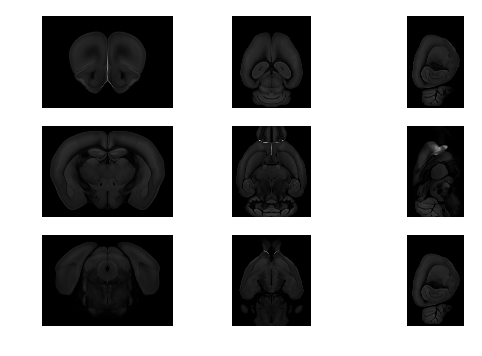

In [4]:
imgShow(refImg)

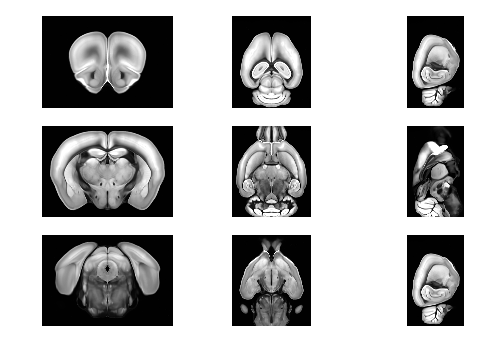

In [5]:
imgShow(refImg, vmax=500)

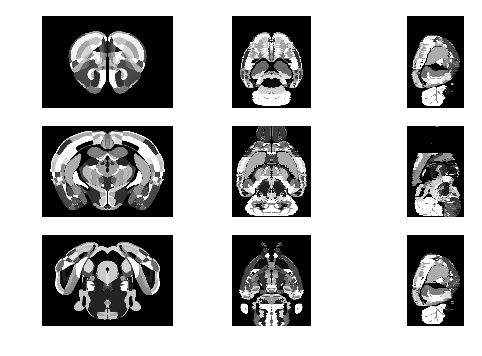

In [6]:
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

In [7]:
randValues = np.random.rand(1000,3)

In [8]:
randValues = np.concatenate(([[0,0,0]],randValues))

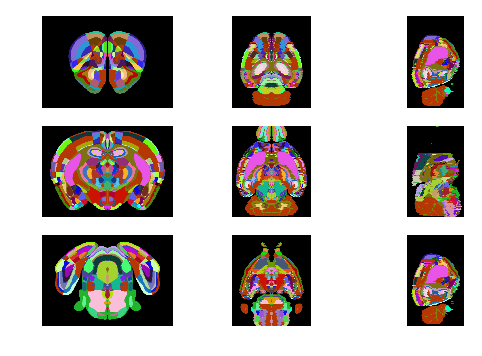

In [9]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

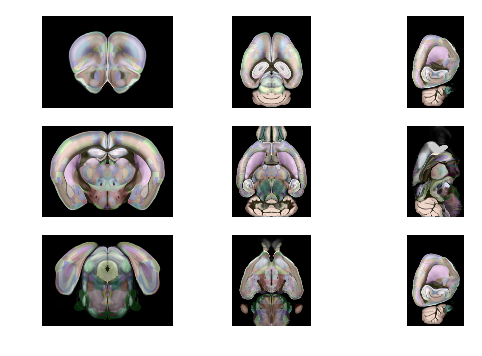

In [10]:
imgShow(refImg, vmax=500, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Downloading localeq brain

In [16]:
inToken = "152DLS_tail/"
nd = neurodata()
print(nd.get_metadata(inToken)['dataset']['voxelres'].keys())

[u'10', u'1', u'0', u'3', u'2', u'5', u'4', u'7', u'6', u'9', u'8']


Clearly resolution 5 is the lowest available resolution.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [19]:
inImg = imgDownload(inToken, resolution=0)
imgShow(inImg, vmax=500)

KeyboardInterrupt: 

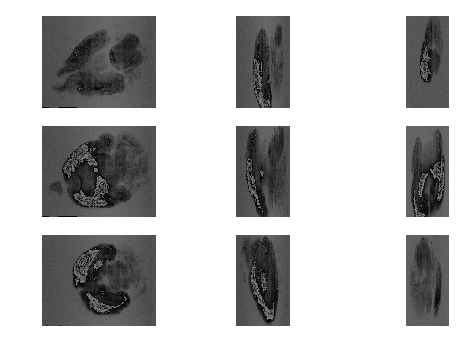

In [34]:
inImg = imgRead("../data/Cocaine174localeq.nii")
#inImg(load_data)
imgShow(inImg, vmax=500)

In [35]:
inImg.SetSpacing([0.01872, 0.01872, 0.005]) # Setting manually due to bug https://github.com/neurodata/ndstore/issues/326

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [36]:
print(inImg.GetSpacing())

(0.01872, 0.01872, 0.005)


In [37]:
print(refImg.GetSpacing())

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


Since we are aliging the CLARITY image to a lower resolution atlas, we can save memory by downsampling it to the resolution atlas.

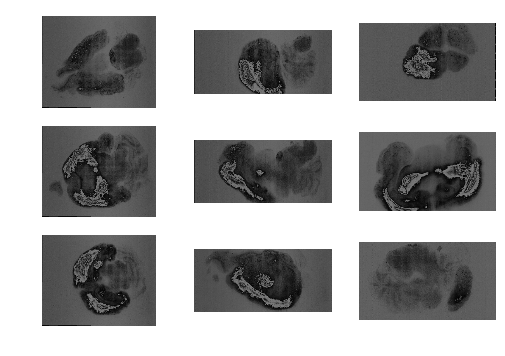

In [38]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

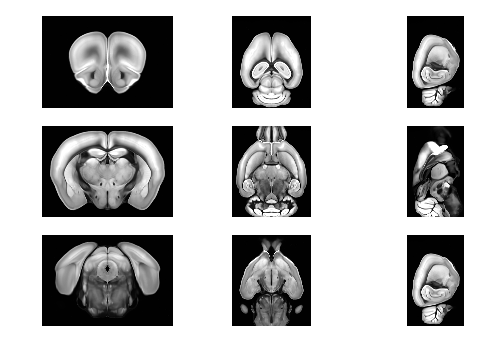

In [39]:
imgShow(refImg, vmax=500)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

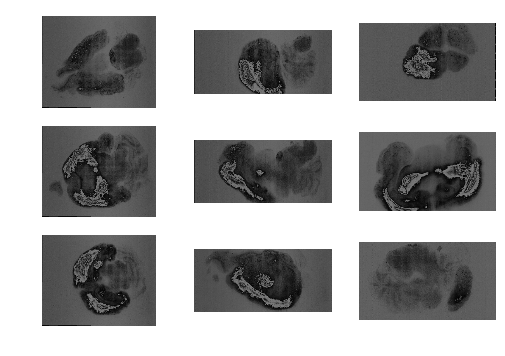

In [40]:
imgShow(inImg, vmax=500)

...we see that the x-axis goes from **L**eft to right, the y-axis goes from **A**nterior to Posterior and the Z axis goes from **I**nferior to Superior.  Thus it's in **LAI** orientation.  Therefore we reorient the CLARITY image from **LAI** to **RSA**

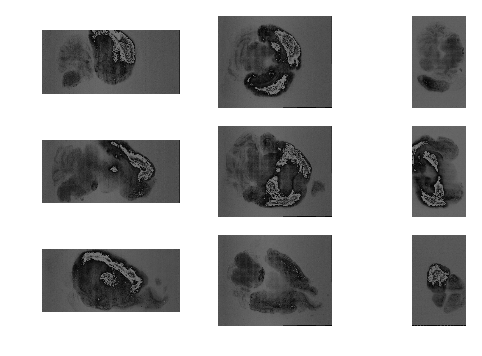

In [41]:
inImg = imgReorient(inImg, "LAI", "RSA")
imgShow(inImg, vmax=500)

Compare the above to the Atlas.  The slices should now correspond with the atlas.

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

In [42]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.

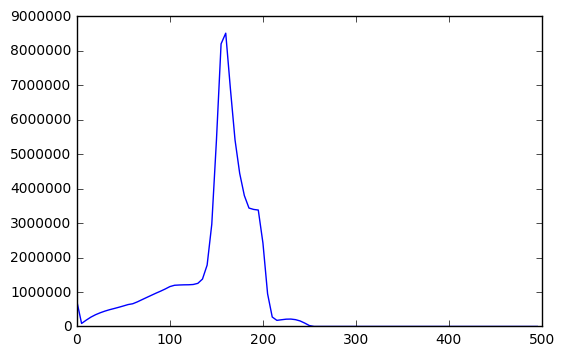

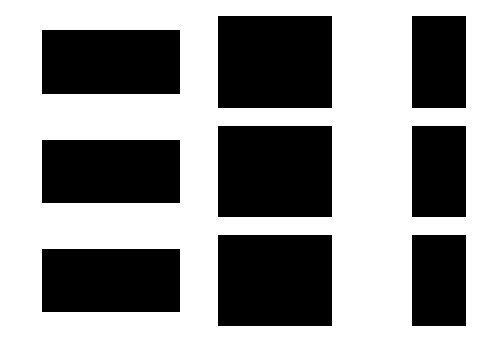

In [33]:
lowerThreshold = 50
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

Here's a histogram of the result

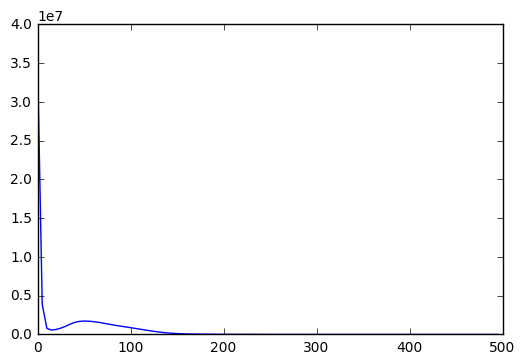

In [53]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

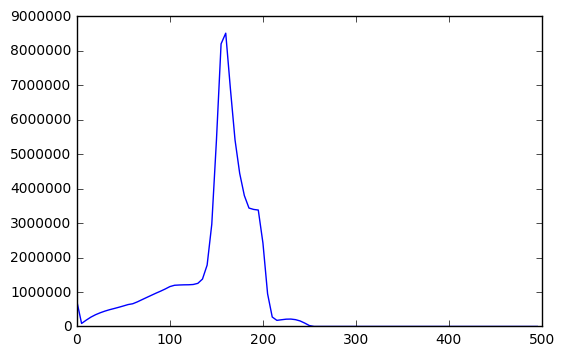

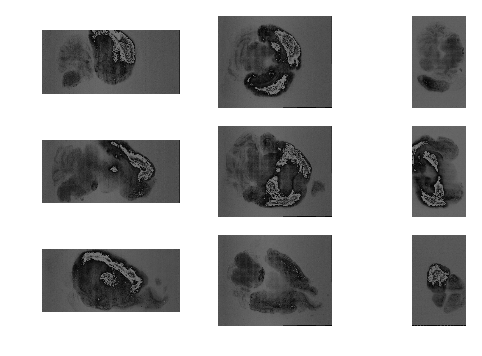

In [43]:
imgShow(inImg, vmax = 500)

To avoid this problem we create a mask which will be used to exclud the top 5% brighest voxels from registration.  To make the mask we first compute the normalized cumulative histogram.

In [44]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=1000)
cumValues = np.cumsum(values).astype(float)
cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

We then find the first value greater than 0.95 (which is 100% - 5%)

In [45]:
maxIndex = np.argmax(cumValues>0.95)-1
threshold = bins[maxIndex]
print(threshold)

200.685


We then threshold the image using this value to obtain a mask

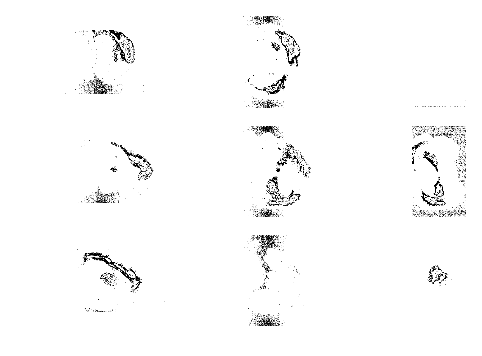

In [46]:
inMask = sitk.BinaryThreshold(inImg, 0, threshold, 1, 0)
imgShow(inMask)

The masked areas will be excluded from the registration

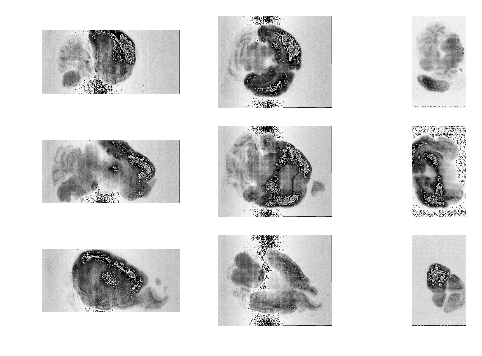

In [47]:
imgShow(imgMask(inImg,inMask))

## Affine Registration
Computer cannot handle even 0.25 so unfortunately spacing is 1.5

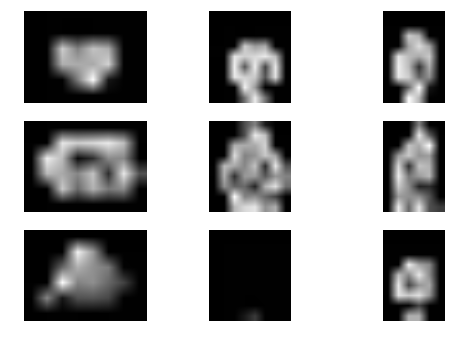

In [48]:
spacing=[1.5,1.5,1.5]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)

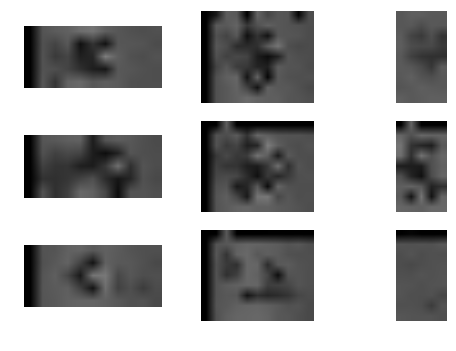

In [49]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=500)

Notice how we used nearest-neighbor interpolation when downsampling the mask

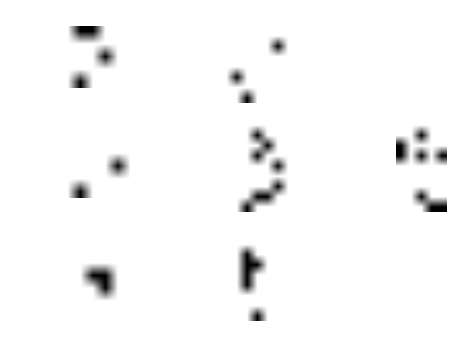

In [50]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [51]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.932512237832
1.	 -0.994157265121
2.	 -0.918982366894
3.	 -0.933536806632
4.	 -0.926278768187
5.	 -0.928232504481
6.	 -0.904507076493
7.	 -0.891604588087
8.	 -0.880679471885
9.	 -0.866333692797
10.	 -0.860524939628
11.	 -0.860904014452
12.	 -0.856765373514
13.	 -0.852739968771
14.	 -0.85602850125
15.	 -0.853869033028
16.	 -0.85152384377
17.	 -0.85211010615
18.	 -0.850838722211
19.	 -0.84838116646
20.	 -0.847232093263
21.	 -0.847350713668
22.	 -0.850027846521
23.	 -0.851460033169
24.	 -0.852623491203
25.	 -0.852504857234
26.	 -0.851361659009
27.	 -0.850270944594
28.	 -0.849274199412
29.	 -0.848375446116
30.	 -0.84766014257
31.	 -0.847416598334
32.	 -0.848060106718
33.	 -0.849376187314
34.	 -0.849902232705
35.	 -0.849969109632
36.	 -0.849395070247
37.	 -0.84809162583
38.	 -0.847503337561
39.	 -0.847475605203
40.	 -0.848392172394
41.	 -0.849592090158
42.	 -0.849974308887
43.	 -0.849917367174
44.	 -0.849117768598
45.	 -0.848583889835
46.	 -0.848152429348
47.	 -0.847

Now we apply the affine transform to the input CLARITY image and mask

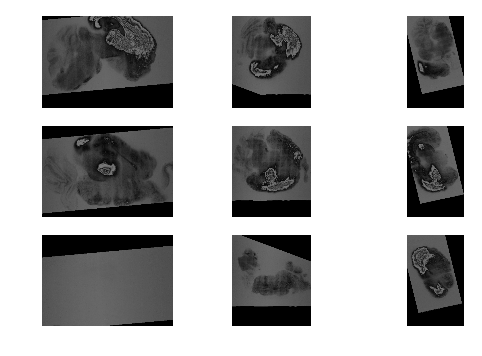

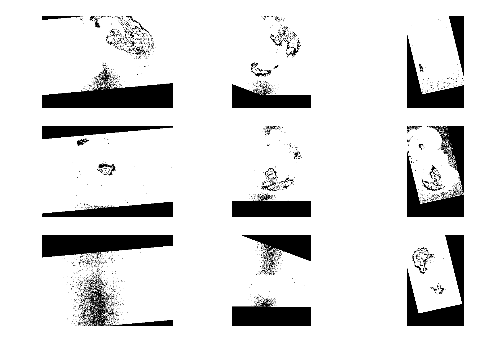

In [52]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg_affine, vmax=500)

inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask_affine)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [basic registration notebook](basicRegistration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.

In [53]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)

In [54]:
inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)

In [55]:
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-6.48808e+10, 2.78054, 0, -6.48808e+10 (99.2205%), 2.685547e-07
1.	-6.50537e+10, 9.77469, 0, -6.50537e+10 (98.9556%), 2.954102e-07
2.	-6.53248e+10, 10.8172, 0, -6.53248e+10 (98.5401%), 8.123779e-08
3.	-6.53458e+10, 11.8686, 0, -6.53458e+10 (98.5079%), 4.468079e-08
E = -6.53287e+10 (98.5342%)
Length = 4.27514
Time = 2.74117s (0.0456862m)

Step 1: alpha=0.02, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-6.53193e+10, 2.30904, 0, -6.53193e+10 (99.9192%), 1.342773e-07
1.	-6.5888e+10, 7.17073, 0, -6.5888e+10 (99.0357%), 1.477051e-07
2.	-6.62084e+10, 8.20608, 0, -6.62084e+10 (98.538%), 4.061890e-08
3.	-6.62195e+10, 8.79145, 0, -6.62195e+10 (98.5207%), 2.234039e-08
4.	-6.62935e+10, 9.52333, 0, -6.62935e+10 (98.4058%), 2.457443e-08
5.	-6.64977e+10, 10.4442, 0, -6.64977e+10 (98.0885%), 2.703188e-08
6.	-6.66796e+10, 11.6931, 0, -6.66796e+10 (97.8058%), 2.973

In [56]:
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())

In [57]:
inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)

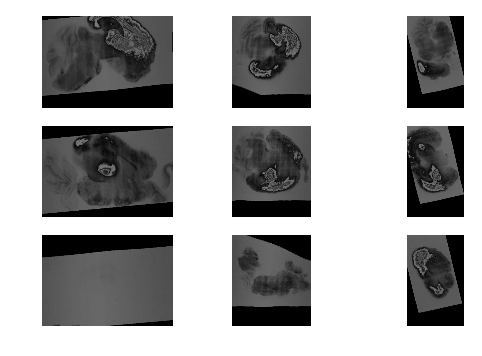

In [58]:
imgShow(inImg_lddmm, vmax = 500)

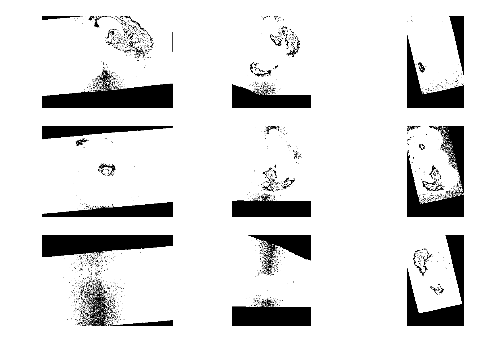

In [59]:
imgShow(inMask_lddmm)

We can now overlay tha ARA annotaions on the CLARITY image.

In [60]:
imgShow(inImg_lddmm, vmax=500, newFig=False, numSlices=1)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False, numSlices=1)

## Evaluating the registration
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

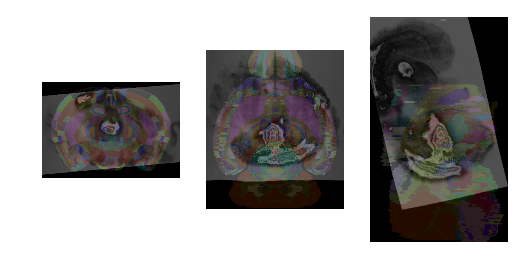

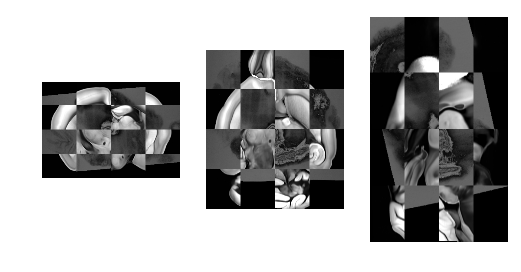

In [61]:
imgShow(imgChecker(inImg_lddmm, refImg, useHM=False), vmax=500, numSlices=1)

We can also evaluate the registration using the negative log Jacobian determinant of the displacement field.  Wherever it's negitive the input CLARITY image contracted during registration.  Wherever it's positive the CLARITY image expanded.

In [62]:
logJDet = -sitk.Log(sitk.DisplacementFieldJacobianDeterminant(field))

Since the field was computed on a downsampled grid we resample *logJDet* to the size of the deformed image.

In [63]:
logJDet = imgResample(logJDet, spacing=inImg_lddmm.GetSpacing(), size=inImg_lddmm.GetSize())

To overlay it on the deformed CLARITY image, we must set *newFig* to *False* so that matplotlib adds the *logJDet* data to the old figure instead of creating a new figure.

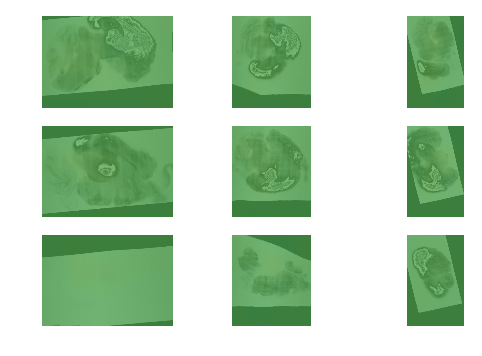

In [64]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
plt.show()

Let's add a colorbar so that it's clear what the color's mean. This is a little tricky so we'll do this one step at a time. First we get the current figure.

In [65]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
fig = plt.gcf()

There a 9 subplots in the figure.

In [66]:
fig.axes

Let's get the axis of the 0th subplot from the figure.

In [67]:
ax = fig.axes[0]

Each subplot has two images two images.  The 0th one is a slice from inImg_lddmm.  The 1st one is a slice from the logJDet.  Since we want the colorbar from logJDet we get the 1st image.

In [68]:
img_ax = ax.get_images()[1]

Now we make room for the colorbar, add an axis for it and the add it to the figure.

In [69]:
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 

Putting it all together.

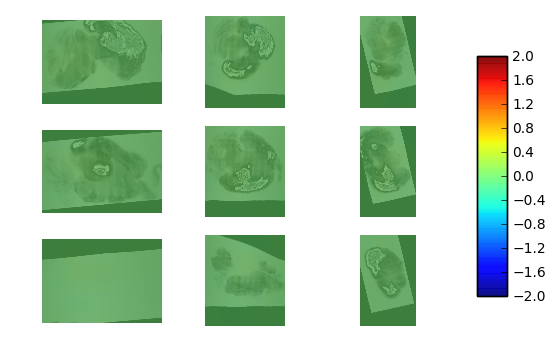

In [70]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
fig = plt.gcf()
ax = fig.axes[0]
img_ax = ax.get_images()[1]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 
plt.show()

Since we see more reds, oranges and yellows than blues it's obious that the CLARITY brain expaned in most places during registration.